In [ ]:
import os
import zipfile
import random
import shutil
import numpy as np
from shutil import copyfile

import tensorflow as tf
from google.colab import files
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras import optimizers

print(tf.__version__)

2.4.1


In [ ]:
os.environ['KAGGLE_USERNAME'] = "xxxxxxxxxx" # username from the json file
os.environ['KAGGLE_KEY'] = "xxxxxxxxxxx" # key from the json file
!kaggle datasets download -d bayuadityatriwibowo/bangkits-peasent-dataset --path '/tmp/'

 99% 616M/621M [00:05<00:00, 114MB/s]
100% 621M/621M [00:05<00:00, 109MB/s]


In [ ]:
local_zip = '/tmp/bangkits-peasent-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
TRAINING_DIR = "/tmp/Bangkit's Peasant Dataset/train/"

Corn_healthy = os.path.join("/tmp/Bangkit's Peasant Dataset/train/Corn_(maize)___healthy")
Potato_healthy = os.path.join("/tmp/Bangkit's Peasant Dataset/train/Potato___healthy")
Tomato_healthy = os.path.join("/tmp/Bangkit's Peasant Dataset/train/Tomato___healthy")

print('total training Healthy Corn images:', len(os.listdir(Corn_healthy)))
print('total training Healthy Potato images:', len(os.listdir(Potato_healthy)))
print('total training Healthy Tomato images:', len(os.listdir(Tomato_healthy)))

Corn_files = os.listdir(Corn_healthy)
print(Corn_files[:10])
Potato_files = os.listdir(Potato_healthy)
print(Potato_files[:10])
Tomato_files = os.listdir(Tomato_healthy)
print(Tomato_files[:10])

total training Healthy Corn images: 1859
total training Healthy Potato images: 1824
total training Healthy Tomato images: 1926
['526e6386-1a1f-4ac3-a49b-770d588faf4f___R.S_HL 7961 copy 2_flipLR.jpg', '6aa92f1b-d5bd-4dcc-a130-925034576462___R.S_HL 8071 copy 2.jpg', '4da561ff-1720-4174-be49-d9680cc1cec3___R.S_HL 8321 copy 2.jpg', 'b4f7d270-984f-4bac-807c-d804ae7b7de2___R.S_HL 8241 copy.jpg', '3b1e3c0f-e493-4d5f-866b-c2274d307471___R.S_HL 0608_flipLR.JPG', '5467efda-f4ec-4f5e-94b8-8bc0fd19c7ac___R.S_HL 8148 copy.jpg', '1ce2a4dc-0c4e-4496-87b9-feae602cc23d___R.S_HL 8204 copy_flipLR.jpg', '12bab18c-050a-4f66-b15d-49a8e19a8d06___R.S_HL 0616.JPG', '4bffb932-0f73-4ea5-b1b3-ffbef8c5f07d___R.S_HL 7895 copy.jpg', '5c0d54a3-39dd-4720-ace7-d571ec6e7b61___R.S_HL 8048 copy.jpg']
['45bc0b37-ca59-4a89-8531-705af42a6fd5___RS_HL 1946_newGGR.JPG', '142fb983-2166-4a0f-b99b-a6c21e99987e___RS_HL 5398_flipLR.JPG', '31a09d39-6791-4ecb-8f44-af2ed85dbd33___RS_HL 1970_newPixel25.JPG', 'd50a580b-46bd-47f5-a0bf-853

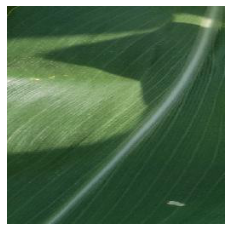

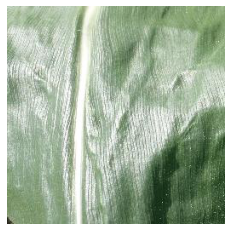

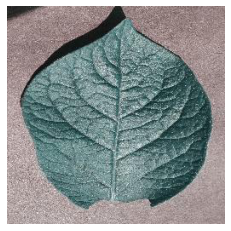

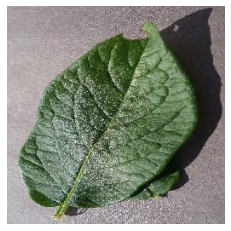

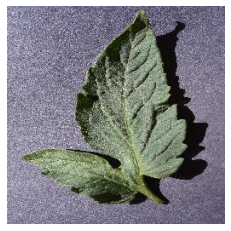

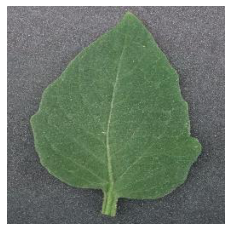

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

Corn_img = [os.path.join(Corn_healthy, fname) 
                for fname in Corn_files[pic_index-2:pic_index]]
Potato_img = [os.path.join(Potato_healthy, fname) 
                for fname in Potato_files[pic_index-2:pic_index]]
Tomato_img = [os.path.join(Tomato_healthy, fname) 
                for fname in Tomato_files[pic_index-2:pic_index]]

for i, img_path in enumerate(Corn_img+Potato_img+Tomato_img):
  #print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

In [ ]:
TRAINING_DIR = "/tmp/Bangkit's Peasant Dataset/train/"
training_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

VALIDATION_DIR = "/tmp/Bangkit's Peasant Dataset/val/"
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(250, 250),
    class_mode='categorical',
    batch_size=128
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(250, 250),
    class_mode='categorical',
    batch_size=128
)

Found 31363 images belonging to 17 classes.
Found 7840 images belonging to 17 classes.


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Pretrained Model + Fine Tuning (https://keras.io/api/applications/)
# create the base pre-trained model : Xception + global spatial average pooling
base_model = Xception(weights='imagenet', input_shape = (250,250,3), include_top=False, pooling = 'avg')

# add a global spatial average pooling layer
x = base_model.output
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
# and a logistic layer -- 18 classes
predictions = Dense(17, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
opt = Adam(lr=0.001, decay = 1e-6, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics = ['accuracy'])

# train the model on the new data for a few epochs
model.fit(train_generator, epochs=4, validation_data = validation_generator, verbose = 1)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from Xception. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

# we chose to train the last inception blocks, i.e. we will freeze
# the first 125 layers and unfreeze the rest:
for layer in model.layers[:125]:
    layer.trainable = False
for layer in model.layers[125:]:
    layer.trainable = True
# we need to recompile the model for these modifications to take effect
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics = ['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history = model.fit(train_generator, epochs=4, validation_data = validation_generator, verbose = 1)

Epoch 1/4
246/246 [==============================] - 444s 2s/step - loss: 1.0527 - accuracy: 0.6719 - val_loss: 0.5353 - val_accuracy: 0.8256
Epoch 2/4
246/246 [==============================] - 413s 2s/step - loss: 0.4745 - accuracy: 0.8389 - val_loss: 0.4826 - val_accuracy: 0.8321
Epoch 3/4
246/246 [==============================] - 413s 2s/step - loss: 0.3917 - accuracy: 0.8650 - val_loss: 0.4615 - val_accuracy: 0.8395
Epoch 4/4
246/246 [==============================] - 419s 2s/step - loss: 0.3637 - accuracy: 0.8787 - val_loss: 0.4278 - val_accuracy: 0.8501
0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_8
13 block2_pool
14 batch_normalization_5
15 add_12
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_9
23 block3_pool

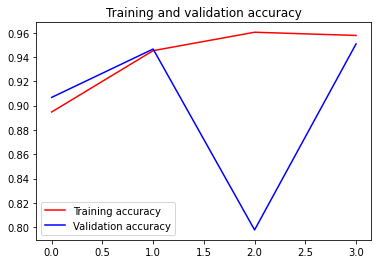

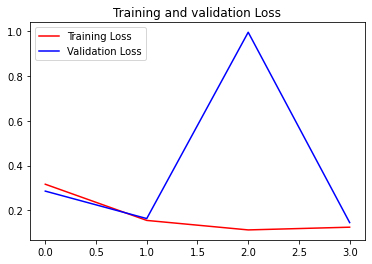

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()

plt.show()

Saving PotatoHealthy1.JPG to PotatoHealthy1.JPG


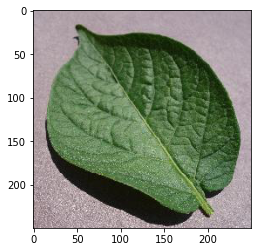

Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 0.00%
Corn_(maize)___Common_rust_: 0.00%
Corn_(maize)___Northern_Leaf_Blight: 0.00%
Corn_(maize)___healthy: 0.00%
Potato___Early_blight: 0.00%
Potato___Late_blight: 0.07%
Potato___healthy: 99.93%
Tomato___Bacterial_spot: 0.00%
Tomato___Early_blight: 0.00%
Tomato___Late_blight: 0.00%
Tomato___Leaf_Mold: 0.00%
Tomato___Septoria_leaf_spot: 0.00%
Tomato___Spider_mites Two-spotted_spider_mite: 0.00%
Tomato___Target_Spot: 0.00%
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.00%
Tomato___Tomato_mosaic_virus: 0.00%
Tomato___healthy: 0.00%


In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.applications.xception import preprocess_input

labels = train_generator.class_indices.keys()

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(250, 250))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  images = np.vstack([x])
  proba = model.predict(images)[0]
  plt.imshow(img)
  plt.show()
  for (label, p) in zip(labels, proba):
    print("{}: {:.2f}%".format(label, p * 100))